# Assignment 05: Ensemble Learning and Random Forests

**Due Date:** Friday 11/22/2024 (by midnight)


**Please fill these in before submitting, just in case I accidentally mix up file names while grading**:

Name: Aidan Corrales

CWID-5: 31600

## Introduction 

In this assignment you will use a dataset from the OpenML repository named
[MagicTelescope](https://openml.org/search?type=data&status=active&id=1120)
You will load this data set and use it to to create some ensemble classifiers, both using voting, and then
also some bagging and stacking type ensembles.

In [3]:
# The following ipython magic will reload changed file/modules.
# So when editing function in source code modules, you should
# be able to just rerun the cell, not restart the whole kernel.
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
#Added by Aidan Corrales
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc

# By convention, we often just import the specific classes/functions
# from scikit-learn we will need to train a model and perform prediction.
# Here we include all of the classes and functions you should need for this
# assignment from the sklearn library, but there could be other methods you might
# want to try or would be useful to the way you approach the problem, so feel free
# to import others you might need or want to try


In [5]:
# Import functions/moduls from this project.  We manually set the
# PYTHONPATH to append the location to search for this assignments
# functions to just ensure the imports are found
import sys
sys.path.append("../src")

# assignment function imports for doctests and github autograding
# these are required for assignment autograding
from assg_utils import run_unittests, run_doctests
from assg_tasks import task_1_load_data, train_val_test_split, task_3_voting_ensemble, task_4_bag_of_trees_ensemble, create_stacked_data, task_6_stacked_ensemble

In [6]:
# notebook wide settings to make plots more readable and visually better to understand
np.set_printoptions(suppress=True)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-v0_8-darkgrid')

## Task 1: Load and Setup MagicTelescope data

The [MagicTelescope](https://openml.org/search?type=data&status=active&id=1120) data set from the OpenML repository
consists of 19020 instances.  There are 10 numeric features in this data set with no missing data.  The
data set consists of various astronomical observations, and is a binary classification task where we want
to classify the observations as either 'g' gamma signal detected or 'h' a hadron or no background signal.
The data set is a bit skewed with 12332 instances of the positive 'g' class and 6688 instances of the
negative 'h' class, so just always guessing positive of 'g' gives a $\frac{12332}{19020} = 0.65$ or
about 65% accuracy.

In the first task, as usual, you need to complete the function to load the data set and clean it up a
bit to be used for this assignment.  You are required to use the `fetch_openml()` method from
`scikit-learn` to load this dataset from the OpenML repository.  There have been examples of using this
to load the 'MNIST' dataset, you can do the same, but use the data set name 'MagicTelescope'

There are a few other things you need to do.  As usual your `task1_load_data()` function is found in
the `src/assg_tasks.py` file.  The function needs to return the `X` set of 19020 instances consisting
of 10 numeric features, and the `y` target labels.  The targets as read from the OpenML function
will be strings. Make sure that you encode the `g` as the positive class 1 and the `h` as the negative class 0,
and you shape the targets as expected to pass the tests for this task to load the data we will
use.  You should probably use an `OrdinalEncoder` so that you can correctly map the original labels as
required ('g' is 1 and 'h' is 0).  The tests expect that you return a NumPy array with shape `(19020,)`, so a vector,
and that you have encoded the targets correctly as described.

In [7]:
# do not remove or modify the code in this cell
X, y = task_1_load_data()
run_unittests(['test_task_1_load_data'])

test_X_properties (test_assg_tasks.test_task_1_load_data.test_X_properties)
test_X_properties ... ok
test_loaded_types (test_assg_tasks.test_task_1_load_data.test_loaded_types)
test_loaded_types ... ok
test_y_properties (test_assg_tasks.test_task_1_load_data.test_y_properties)
test_y_properties ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.813s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In addition to loading the data, perform some exploration of this data set so that you better understand it.  
Do the following tasks in the cell(s) below

1. Verify that all of the features are numeric and that there is no missing data in this data set.
2. We won't do any further data cleaning, but look at the feature ranges.  Does it look like features have
  different scales and thus maybe we should try scaling it?
3. Determine the correlation between each feature and the binary target label
4. Plot the two most correated features.  In the plot also indicate the target of each point using
  marker type and/or color, so we can visualize if there is any pattern among most correlated
  features and the target we are trying to predict.

In [8]:
# 1. verify all features are numeric and that there is no missing data
print("Data types:\n", X.dtypes)
print("\nMissing values:\n", X.isnull().sum())

Data types:
 fLength:     float64
fWidth:      float64
fSize:       float64
fConc:       float64
fConc1:      float64
fAsym:       float64
fM3Long:     float64
fM3Trans:    float64
fAlpha:      float64
fDist:       float64
dtype: object

Missing values:
 fLength:     0
fWidth:      0
fSize:       0
fConc:       0
fConc1:      0
fAsym:       0
fM3Long:     0
fM3Trans:    0
fAlpha:      0
fDist:       0
dtype: int64


In [9]:
# 2. The mean and the min/max have different ranges
print("\nFeature ranges:\n", X.describe().loc[['min', 'max']])


Feature ranges:
      fLength:  fWidth:  fSize:  fConc:  fConc1:    fAsym:  fM3Long:  \
min    4.2835    0.000  1.9413  0.0131   0.0003 -457.9161  -331.780   
max  334.1770  256.382  5.3233  0.8930   0.6752  575.2407   238.321   

     fM3Trans:  fAlpha:    fDist:  
min  -205.8947      0.0    1.2826  
max   179.8510     90.0  495.5610  


In [10]:
# 3. Determine the correlation between each feature and the binary target label
correlations = X.copy()
correlations['target'] = y
feature_corr = correlations.corr()['target'].drop('target')
print("\nCorrelation of each feature with the target:\n", feature_corr.sort_values(ascending=False))


Correlation of each feature with the target:
 fM3Long:     0.193409
fAsym:       0.173587
fConc:       0.024615
fConc1:      0.004797
fM3Trans:   -0.003837
fDist:      -0.065203
fSize:      -0.117795
fWidth:     -0.265596
fLength:    -0.307572
fAlpha:     -0.460979
Name: target, dtype: float64


Most correlated features: fAlpha: and fLength:


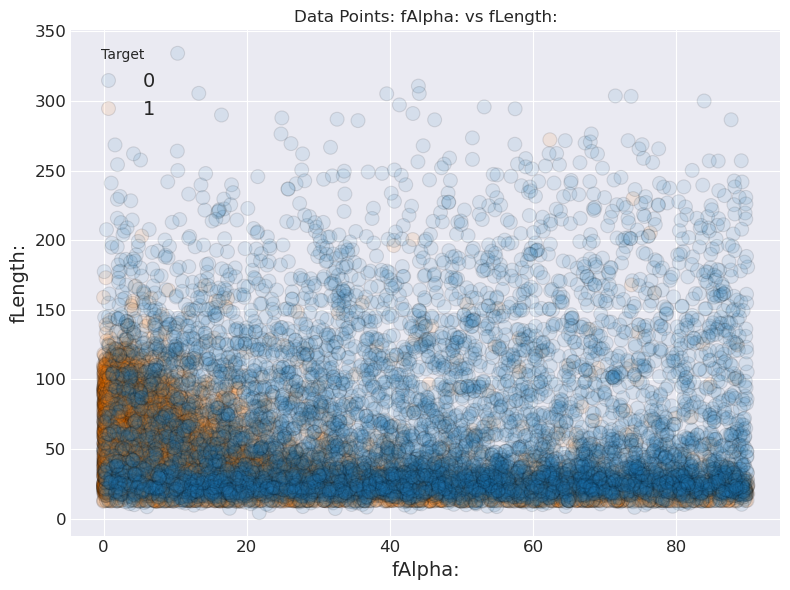

In [14]:
# 4. plot the two most correlated features and visualize the signal on the plot using marker type/color
top2_features = feature_corr.abs().sort_values(ascending=False).head(2).index.tolist()
feature1, feature2 = top2_features
print(f"Most correlated features: {feature1} and {feature2}")

plt.figure(figsize=(8, 6))

sns.scatterplot(data=X, x=feature1, y=feature2, hue=y, palette='tab10', s=100, edgecolor='k', alpha=0.1)

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'Data Points: {feature1} vs {feature2}')
plt.legend(title='Target')
plt.grid(True)
plt.tight_layout()
plt.show()

## Task 2: Utility Function for Train/Validation/Test Split

In this section you are going to write a small utility function, for some more practice with
using Python functions and the `sklearn` preprocessing library.

There is a method in `sklearn` named `train_test_split()` that we have seen before and that can be used
to split some data `X` and its targets `y` into training and testing data
sets.  This function, by default, shuffles the data and performs the split as
asked, using an absolute number of samples or a ratio to determine
how much to split into the test set and how much into the training set.

Create a function named `train_val_test_split()` that will split a set of data into
3 sets, a training set, a validation set and a test set.  You are required to
reuse the `train_test_split()` funciton in your implementation.  You should basically
first split the data into the training data and the remaining data with one call of 
`train_test_split()` in your function, then call it a second time to split the
remaining into a validation and final testing data set.

The function is given in the `src/assg_tasks.py` file as usual.  The function expects
the `X` input samples and the `y` labels as inputs to be split.  It also expects 2 parameters, the
training set size and the validation set size (we won't support splitting by a ratio
in this funciton, only by absolute number of samples to end up in each set).

Implement the function so that it passes the tests given.  The function also has a
`random_seed` with a default value of 42.  You should set the random state for both calls
to `train_test_split()` when performing your 3-way split using this seed.  The random state is set to
a different seed each time sklearn calls `train_test_split()` so if  you don't specify
the seed everytime the function is called, the split from your implementation will
not be reproducible as required.

In [15]:
# do not remove or modify the code in this cell
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_size=10000, val_size=4510)
run_unittests(['test_train_val_test_split'])

test_assg_data (test_assg_tasks.test_train_val_test_split.test_assg_data)
test_assg_data ... ok
test_generated_data (test_assg_tasks.test_train_val_test_split.test_generated_data)
test_generated_data ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.106s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## Task 3: Voting Ensemble Classifier

In this task you will be creating a voting classifier as we have seen in our materials this week and
train it on the `MagicTelescope` data we are using for this assignment.

Implement the function named `task_3_voting_classifier()` in the `src/assg_tasks.py` module.  In this task we are going to create
5 separate classifiers that will be added and trained with the voting classifier.  The function for this task should create
the following 5 classifiers:

1. 'knn': A k-nearest neighbors classifier
2. 'dt': A basic decision tree classifier
3. 'lr': A logistic regression classifier
4. 'svc': A support vector classifier
5. 'mlp': A multi-layer perceptron classifier (basically a neural network).

In most all cases, just use the default classifier, do not specify any additional meta parameters for the object when you create it.  With the exception of
the following cases:

- For the logistic regression classifier, specify: `solver='sag'` and `max_iter=10000`, so that the model will converge when trained on the data.
- For the support vector classifier use: `probability=True` so that we can use it in a soft voting ensemble.

We will not be discussing neural network or multi-layer perceptrons in this class and have not used them before.  The `scikit-learn` object name for that type of classifer is simply `MLPClassifier` and it should just use the default parameters for that type of classifier.

Make sure that you use the names shown above in the numbered list for each classifier instance when creating the voting classifier.  The tests of this
task/function assume that they can access the classifiers in the returned voting ensemble by the names shown in the list.

### Hard Voting Ensemble 

The data to train the voting ensemble is passed in to the function you are creating for this tasks.  Besides the data and labels, whether to use hard or soft
voting is passed in as the third parameter.  Make sure you correctly use this parameter when creating  your voting ensemble so that we can test performance
with either hard or soft voting.  And finally the tests expect that the returned voting ensemble is fit on the training data given.

In [42]:
# do not remove or modify the code in this cell
vc = task_3_voting_ensemble(X_train, y_train, voting='hard')
run_unittests(['test_task_3_hard_voting_ensemble'])

test_dt_estimator (test_assg_tasks.test_task_3_hard_voting_ensemble.test_dt_estimator)
test_dt_estimator ... ok
test_knn_estimator (test_assg_tasks.test_task_3_hard_voting_ensemble.test_knn_estimator)
test_knn_estimator ... ok
test_lr_estimator (test_assg_tasks.test_task_3_hard_voting_ensemble.test_lr_estimator)
test_lr_estimator ... ok
test_mlp_estimator (test_assg_tasks.test_task_3_hard_voting_ensemble.test_mlp_estimator)
test_mlp_estimator ... ok
test_svc_estimator (test_assg_tasks.test_task_3_hard_voting_ensemble.test_svc_estimator)
test_svc_estimator ... ok
test_voting_ensemble (test_assg_tasks.test_task_3_hard_voting_ensemble.test_voting_ensemble)
test_voting_ensemble ... ok

----------------------------------------------------------------------
Ran 6 tests in 237.356s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

The voting classifier ensemble is returned from your task 3 function if you implemented it correctly.
In the following cell(s) access the individual trained classifiers and report the performance of
each individual classifier on the data it was trained with and on the validation data set that
you should have available.  Do you notice any surprises?  Are the individual classifiers
performing ok on the validation data, e.g. how does it compare to always guessing 1 (gamma signal)?
Which classifier performs the best? Which is the worst?

**HINT**: be careful, there are ways to access both the original estimators and the resulting fitted
estimators.  You should be accessing the fitted estimators and reporting the accuracy performance
on each individual estimator.  Also it would be best to access the estimators by name since this is alwo how
we test your work in this task.

In [18]:
# access the individual named classifiers in the ensemble and report accoracy on both the training data and the validation data here

for name, clf in vc.named_estimators_.items():
    train_accuracy = clf.score(X_train, y_train)
    
    val_accuracy = clf.score(X_val, y_val)
    
    print(f"{name} - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


knn - Train Accuracy: 0.8572, Validation Accuracy: 0.8020
dt - Train Accuracy: 1.0000, Validation Accuracy: 0.8149
lr - Train Accuracy: 0.7871, Validation Accuracy: 0.7860
svc - Train Accuracy: 0.8227, Validation Accuracy: 0.8182
mlp - Train Accuracy: 0.8347, Validation Accuracy: 0.8142


If you did not modify the cell above then the classifier that you returned should be using
hard voting.  Report the accuracy of the overall hard voting model in the next cell(s).

Usually in my testing the performance on the unseen validation data will be at least as good as the
best individual model, and usually shows some slight (though perhaps not significant) improvement
in performance when using hard voting.

In [19]:
# report the hard voting ensemble accuracy on both training and validation data here
train_accuracy = vc.score(X_train, y_train)

val_accuracy = vc.score(X_val, y_val)

print(f"Hard Voting Ensemble - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Hard Voting Ensemble - Train Accuracy: 0.8657, Validation Accuracy: 0.8282


### Soft Voting Ensemble

Now create another model (and run the tests), this time using soft voting.  The fitted individual models should not have changed
here, they are all still being fit on the same training data.  But rerun your report of the performance of the
voting ensemble using soft voting.  You should usually find a small but probably significant (1% or so) improvement
over the hard voting ensemble results.

In [20]:
# do not remove or modify the code in this cell
vc = task_3_voting_ensemble(X_train, y_train, voting='soft')
run_unittests(['test_task_3_soft_voting_ensemble'])

test_voting_ensemble (test_assg_tasks.test_task_3_soft_voting_ensemble.test_voting_ensemble)
test_voting_ensemble ... ok

----------------------------------------------------------------------
Ran 1 test in 42.795s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [21]:
# report the soft voting ensemble accuracy on both the training and alidation data here
train_accuracy_soft = vc.score(X_train, y_train)

val_accuracy_soft = vc.score(X_val, y_val)

print(f"Soft Voting Ensemble - Train Accuracy: {train_accuracy_soft:.4f}, Validation Accuracy: {val_accuracy_soft:.4f}")

Soft Voting Ensemble - Train Accuracy: 0.9080, Validation Accuracy: 0.8350


## Task 4: Bagging Classifier (Random Forest or Extra Trees)

So far you have created a voting ensemble using a collection of very different types of
machine learning algorithms.  We have not yet asked you to try and optimize the performance
of the individual estimators nor the ensemble.

As you should have learned from this week, we can create an ensemble in a different way,
by ensembling a large number of the same type of estimator, but trying to differentiate
them by having them sample only a subset of the inputs or the features of the
data we want to model.  These are known as **Bagging** and **Pasting** types of ensembles.
In fact random forests are sometimes refered to as a **Bag of Trees**.  Bagging ensembles
are a much more commonly used ensemble than voting ensembles, and thus `scikit-learn` has
random forest and extra trees classifiers as basic types in the library to create and use.

This task is a bit more open ended than the previous one.  For this task complete the
`task_4_bagging_ensemble()` function to create and fit a bagging type classifier on our
`MagicTelescope` dataset.  For this task you can use either a Random Forest or
an Extra (random) Trees classifier from `scikit-learn`.  Your goal in this section is
to explore the parameters for these and try and find a bagging classifier that will beat
the voting ensemble performance you achieved in the previous task (should not be that difficult).
We did not optimize the previous ensemble, so you should be able to find a bagging ensemble that will do
better than the voting ensemble from the previous task.  Don't forget to try
different values of the `n_estimators`, this will have the most effect on a
bag of classifiers, as well as exploring some of the other tree regularization
parameters.

As usual complete the `task_4_bagging_ensemble()` function in the `src/assg_tasks.py` 
module file.  The tests for this task only check that you use a random forest or an
extra tree, and that you are getting a reasonably improved accuracy on the ensemble
you create and fit for this task.

In [26]:
# do not remove or modify the code in this cell
bag = task_4_bag_of_trees_ensemble(X_train, y_train)
run_unittests(['test_task_4_bag_of_trees_ensemble'])

test_bag_of_trees_ensemble (test_assg_tasks.test_task_4_bag_of_trees_ensemble.test_bag_of_trees_ensemble)
test_bag_of_trees_ensemble ... ok

----------------------------------------------------------------------
Ran 1 test in 3.705s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

If we were attempting to compete in a competition to get the best performing
classifier for the MagicTelescope data, we would probably want to pay close
attention to the ROC area under the curve characteristics of the models
we were creating and testing.  In the following cell(s) 

1. Calculate the accuracy on the training data and the validation data for the
   ensemble you created and returned in the task 4 function.
2. Display the confusion matrix of your bag of trees classifier on the validation
   data.
3. Generate the ROC area under the curve performance for your ensemble classifier.

In [33]:
# 1. show accuracy on training and validation data of your bag of trees here
train_accuracy_bagging = bag.score(X_train, y_train)
val_accuracy_bagging = bag.score(X_val, y_val)

print(f"Random Forrest training accuracy: {train_accuracy_bagging:.4f}")
print(f"Random Forrest validation accuracy: {val_accuracy_bagging:.4f}")

Random Forrest training accuracy: 0.9143
Random Forrest validation accuracy: 0.8636


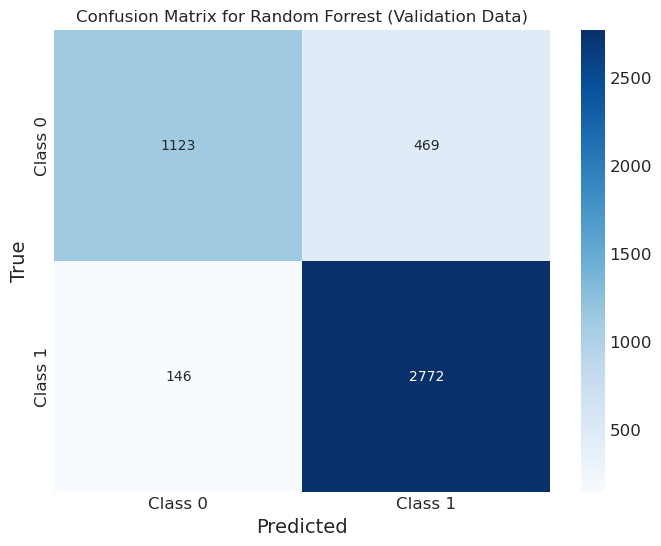

In [34]:
# 2. display confusion matrix
y_pred = bag.predict(X_val)

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Random Forrest (Validation Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

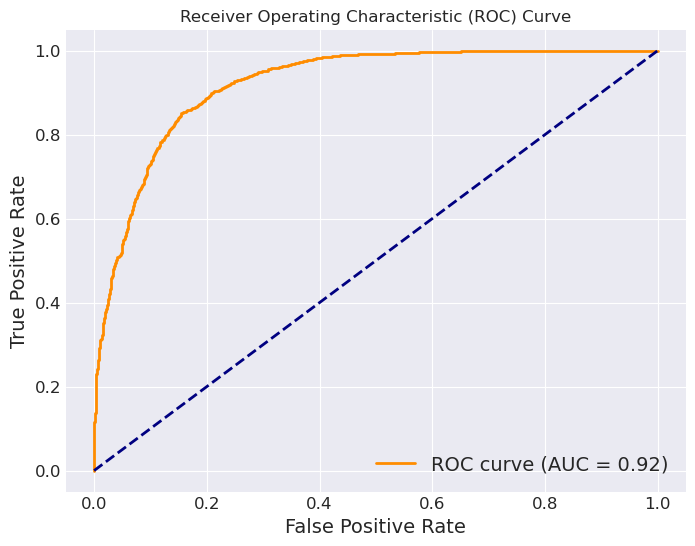

In [37]:
# 3. plot ROC AOC curve
y_pred_prob = bag.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Task 5: Utility Function for Training Data Stacking

For your final two tasks we are going to be stacking the output of the set of 5 diverse estimators
you created for the voting ensemble, and using this to train a new estimator to make the final prediciton (rather than simply
taking a vote).  This is called a stacking ensemble by our textbook.

It will be useful to have a utility function that will do some of the work we will need
to create the stacked ensemble.  In this task you need to write a function
named `create_stacked_data()`.  This function expects a `VotingClassifier`
that has been fit and trained, and a set of `X` input data.
You will be reusing the voting ensemble created in task 3, and will 
be using the estimators in the voting ensemble as the base estimators for the stacked
ensemble you will create for the task 6.

So for this function, you need to do the following:

1. Iterate and access each estimator in the voting ensemble you are given as the first parameter
   - Each estimator is already trained, so ask it to make probability
     predictions on the input data `X` given.
   - Gather all of the outputs into a regular python list.
2. The list of probability outputs then needs to be stacked
   horizontally.  For example, for our training data we have 5000 samples,
   meaning that each estimator should generate a `(5000, 2)` shaped array
   giving the probability of class 0 'h' and class 1 'g' respectively.  Stacking
   these outputs for the 5 estimators should result in a `(5000, 10)`
   shaped array that can be used as the input for a blending estimator.

So in the following cell(s), complete the `create_stacked_data()` utility function
so that it passes the tests for this task.  This function expects a voting
ensemble that has already been fit and trained.  You will reuse the
estimators of this ensemble as base estimators for the stacking task.  You 
are also given the inputs `X` that we need to generate probability estimates
from the base estimators for.  This function returns the stacked
outputs from all of the base estimators.

In [38]:
# do not remove or modify the code in this cell
X_stacked = create_stacked_data(vc, X_train)
run_unittests(['test_create_stacked_data'])

test_stack_random_data (test_assg_tasks.test_create_stacked_data.test_stack_random_data)
test_stack_random_data ... ok
test_stack_validation_data (test_assg_tasks.test_create_stacked_data.test_stack_validation_data)
test_stack_validation_data ... ok

----------------------------------------------------------------------
Ran 2 tests in 76.894s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## Task 6: Create a Stacking Classifier by Hand

As we implied in the previous task, you will be creating a stacked ensemble classifier by hand for this
final task of the assignment.  You will be reusing your task 3 voting ensemble method, so that
you don't have to recreate the work in training individual estimators to be stacked.
So when implementing your `task_6_stacked_ensemble()` you should first simply call your
`task_3_voting_ensemble()` method to train and fit the same 5 estimators again on the
training data that is passed into this function.

But you will not be using the voting ensemble in this method, you will simply want to
access the trained estimators so you can create a stacked ensemble from them.  So after
training the individual estimators using your previous method, perform the following:

1. Reuse your task 3 function to train and fit a voting ensemble on the given training
   data.  The estimators in this ensemble will be used as the base estimators of the stack.
2. Reuse your `create_stacked_data()` function to stack the probability predictions of each of the
   named estimators into a new resulting array.  Make sure that the stacked data is
   created using the validation data set passed in to this function.
3. Create a new classifier to train on this new input.  For this task use
   a `SVC` classifier to train for the final blending.  Make sure that you correctly train
   it using your stacked data from the validation inputs, and the `y` validation labels.
4. This function should then return the `blending_estimator` and the `voting_ensemble` that
   were trained and fit by your function on the training and validation data.

The tests again are relatively simple for this function, they just check that you are
creating and returning a `SVC` for the blending estimator and that it gets expected performance
on the training and validation data.

In [44]:
# do not remove or modify the code in this cell
blending_estimator, voting_ensemble = task_6_stacked_ensemble(X_train, y_train, X_val, y_val)
run_unittests(['test_task_6_stacked_ensemble'])

test_blending_estimator (test_assg_tasks.test_task_6_stacked_ensemble.test_blending_estimator)
test_blending_estimator ... ok
test_voting_ensemble (test_assg_tasks.test_task_6_stacked_ensemble.test_voting_ensemble)
test_voting_ensemble ... ok

----------------------------------------------------------------------
Ran 2 tests in 85.170s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

Lets evaluate the performance a bit of this stacked classifier.  First of all, calculate the overall accuracy using both the training data as input to the
stack, and the validation data as input to the stack.  To do this, you have to recreate some of the work you just did in your function.  You will need to generate
the stacked output for the train and validation sets, and use that to ask for the accuracy scores from the final `blending_estimator` that was returned.
You should reuse your `create_stacked_data()` function to do this.
Report the accuracy on the training data and validation data in the next cell(s).

In [45]:
# first report accuracy score on training data set
train_stacked_data = create_stacked_data(vc, X_train)
train_accuracy = blending_estimator.score(train_stacked_data, y_train)

print(f"Training Accuracy of Stacked Classifier: {train_accuracy:.4f}")

Training Accuracy of Stacked Classifier: 0.9165


In [46]:
# now report accuracy score on validation data set
val_stacked_data = create_stacked_data(vc, X_val)
val_accuracy = blending_estimator.score(val_stacked_data, y_val)

print(f"Validation Accuracy of Stacked Classifier: {val_accuracy:.4f}")

Validation Accuracy of Stacked Classifier: 0.8492


You should compare your accuracy score to the result you had for the soft voting classifier, as this is
the most similar model.  We have simply replaced the soft vote with a new blending estimator to 
decide on the final answer.

However, if you created the model correctly, then you used the training data set to train the base
models in the voting ensemble, and you used the validation data set to generate training data to train
the blender estimator.  So it is unfair to use either of these to evaluate the performance of the
stacked model here, both were seen in the training of various estimators in the stack.

So instead in the next cell(s) evaluate the stacked model on the unseen test data set, which we have
not used at all in this assignment up to the point.  Show the accuracy again on the held back test data.
But also show the confusion matrix and the ROC curve for the stacked model results here.

In [47]:
# accuracy on unseen test data
test_stacked_data = create_stacked_data(vc, X_test)
test_accuracy = blending_estimator.score(test_stacked_data, y_test)
print(f"Test Accuracy of Stacked Classifier: {test_accuracy:.4f}")

Test Accuracy of Stacked Classifier: 0.8457


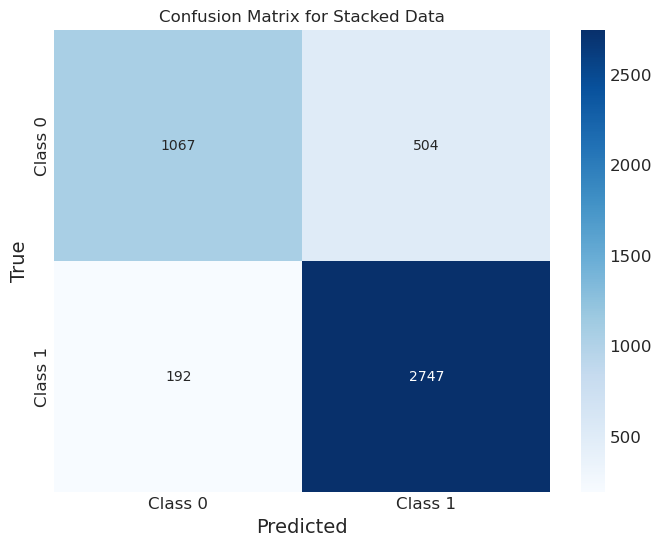

In [49]:
# confusion matrix
y_pred_test = blending_estimator.predict(test_stacked_data)
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Stacked Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

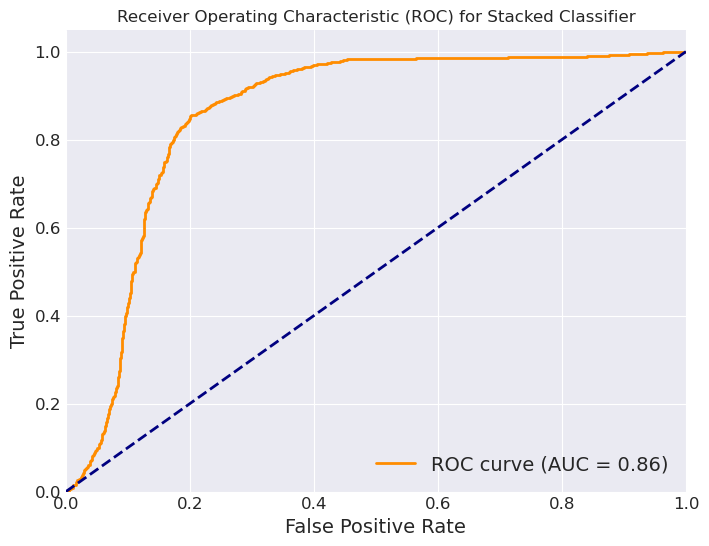

In [50]:
# ROC area under curve for the stacked ensemble
fpr, tpr, _ = roc_curve(y_test, blending_estimator.predict_proba(test_stacked_data)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Stacked Classifier')
plt.legend(loc='lower right')
plt.show()

If you performed the stacking ensemble correctly, you should usually find that it will give
about the same performance as the soft voting classifier.  Usually it will be a bit above,
but not obviously significantly so. 

And comparing this to the bag of trees classifer you created for task 4, usually the
soft votining and stacking classifiers will not be quite as good as easily discovered
bag of trees.  Though we have not had you try and tune any of the base estimators
yet, so probably it would be easy to match the bag of trees with the base estimators
we have been using here, with a bit of tuning.